# Классификация спектров

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale as std_scale, robust_scale

from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd

In [2]:
l1_reg = funcs2.AbsoluteNorm()
l2_reg = funcs2.SquareNorm()
lq_reg = funcs2.PowerNorm(1.001)
softl1_reg = funcs2.SoftAbsoluteNorm(0.00001)

In [3]:
hinge_loss = loss.MarginLoss(funcs.Hinge(0.0))
negmargin_loss = loss.NegMargin()
sq_loss = loss.SquareErrorLoss()

In [4]:
def plot_spectra(d, ax=None):
    if ax is None:
        ax = plt.gca()
    for i, key in enumerate(d):
        Xs, Ys = d[key]
        if key == '191':
            color = 'b'
            label = "B"
        if key == '606':
            color = 'r'
            label = "A"
    
        ax.plot(np.mean(Ys, axis=0), color=color, linewidth=2.0, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    ymax = mod.param.base[1:].copy()
    ymin = mod.param.base[1:].copy()
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


## Линейная модель

$$
f(\mathbf{x}) = w_0 + (\mathbf{w}, \mathbf{x})
$$

In [5]:
def load_data(root, scale='arith'):
    import os
    d = {}
    for fold in os.listdir(root):
        Xs = []
        Ys = []
        for fname in os.listdir(f"{root}/{fold}"):
            if not fname.endswith(".txt"):
                continue
            with open(f"{root}/{fold}/{fname}", 'rt') as h:
                xs, ys = [], []
                dys = []
                for line in h.readlines():
                    line = line.strip()
                    line = line.split()
                    line = [float(val) for val in line]
                    x = line[0]
                    y = line[1:]
                    xs.append(x)
                    ys.append(y)
                xs = np.array(xs[37:], 'd')
                ys = np.array(ys[37:], 'd')
                # ym = np.median(ys, axis=1)
                ys_sorted = np.sort(ys, axis=1)
                ym = np.mean(ys_sorted[:,:27], axis=1)
                ys = ym
                if scale == 'arith':
                    ys -= ys.min()
                    ys_max = ys.max()
                    # ys /= 1000
                    ys /= ys_max
                elif scale == 'mult':
                    ys_min = ys.min()
                    ys /= ys_min
                    ys -= 1
                    # ys = np.log(ys)
                elif scale == 'l1':
                    ys -= ys.min()
                    ys /= ys.sum()
                    ys *= 100
                elif scale == 'std':
                    ys = std_scale(ys)
                    ys_min = ys.min()
                    ys -= ys_min
                elif scale == 'robust':
                    ys = robust_scale(ys)
                    ys_min = ys.min()
                    ys -= ys_min
                Xs.append(xs)
                Ys.append(ys)
        Xs, Ys =  np.array(Xs), np.array(Ys)
        
        if '191' in fold:
            d['191'] = (Xs, Ys)
        if '606' in fold:
            d['606'] = (Xs, Ys)
            
    return d

In [6]:
d = load_data("Table", scale='arith')

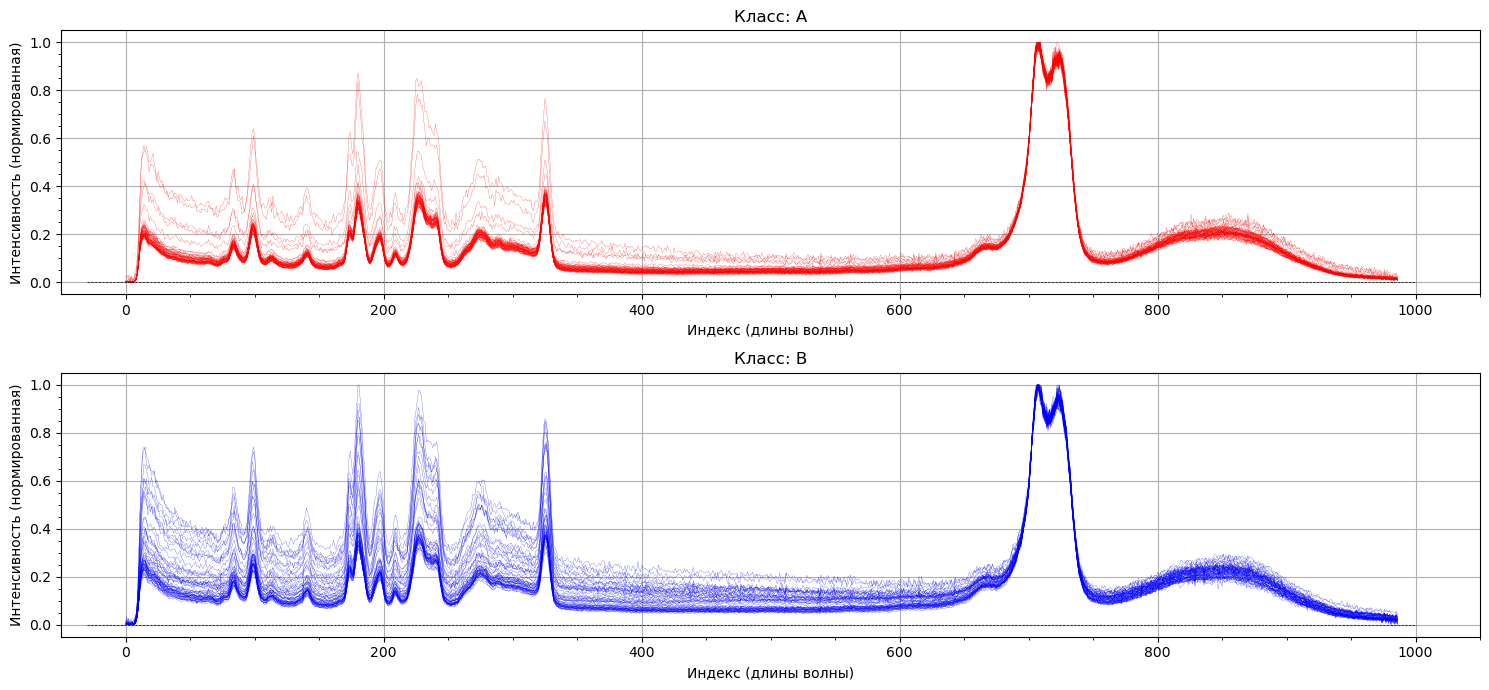

In [7]:
plt.figure(figsize=(15,7))
for i, key in enumerate(d):
    plt.subplot(2,1,i+1)
    Xs, Ys = d[key]
    if key == '191':
        color = 'b'
        title = "B"
    if key == '606':
        color = 'r'
        title = "A"
    
    for xs, ys in zip(Xs, Ys):
        plt.plot(ys, color=color, linewidth=0.15)
        
    plt.hlines(0, -30, 1000, linewidth=0.5, colors='k', linestyle='--')
    plt.xlim(-50, 1050)
    plt.minorticks_on()
    plt.xlabel("Индекс (длины волны)")
    plt.ylabel("Интенсивность (нормированная)")
    plt.title(f"Класс: {title}")
    plt.grid(1)
plt.tight_layout()
plt.show()


In [8]:
for i, key in enumerate(d):
    Xs, Ys = d[key]
    if key == '606': # А
        XX2 = Ys
        YY2 = np.full(len(Ys), +1, 'd')
        print(f"Класс A: {len(Ys)} спектров")
    if key == '191': # B
        XX1 = Ys
        YY1 = np.full(len(Ys), -1, 'd')
        print(f"Класс B: {len(Ys)} спектров")

XX = np.concatenate((XX1, XX2), axis=0) 
YY = np.concatenate((YY1, YY2), axis=0) 
print(f"Всего {len(XX)} спектров")

print("Класс A: метка +1")
print("Класс B: метка -1")

XX = np.ascontiguousarray(XX)
YY = np.ascontiguousarray(YY)

N, n = XX.shape
print(r"Размерность вектора x:", n)

Класс A: 61 спектров
Класс B: 61 спектров
Всего 122 спектров
Класс A: метка +1
Класс B: метка -1
Размерность вектора x: 987


### Линейное разделение (функция Хинжа, без регуляризации)

$$
w^\star = \arg \min_{\mathbf{w}} 
\frac{1}{N}\sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr)
$$
$$
H(u) = \max(-u,0)
$$

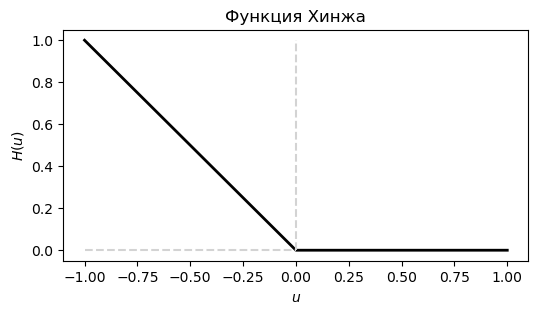

In [9]:
# График функции Хинжа
plt.figure(figsize=(6,3))
plt.plot([-1,0,1],[1,0,0], linewidth=2, color='k')
plt.title("Функция Хинжа")
plt.hlines(0,-1,0, linestyles='dashed', color='LightGrey')
plt.vlines(0,0,1, linestyles='dashed', color='LightGrey')
plt.xlabel(r"$u$")
plt.ylabel(r"$H(u)$")
plt.show()

In [10]:
mod1 = models.LinearModel(n) # линейная модель

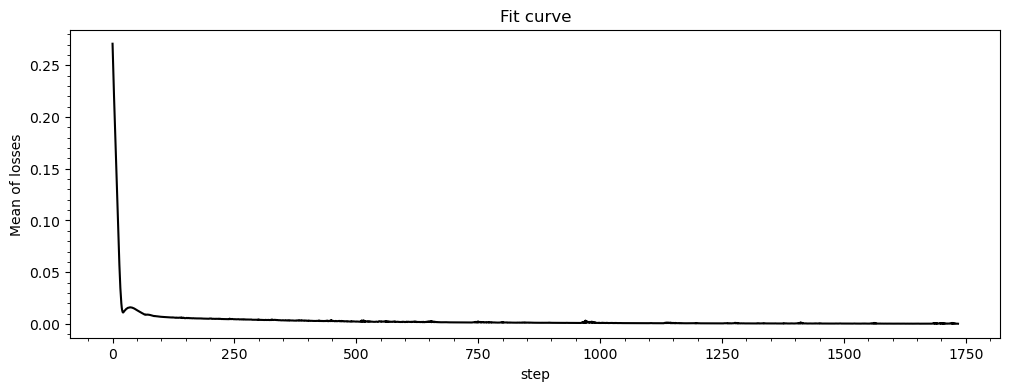

Относительное число правильных ответов: 0.9836065573770492


In [11]:
alg1 = cls.classification_as_regr(XX, YY, mod1,
                                  lossfunc=hinge_loss, 
                                  normalizer=gd.Masked(mod1, 1.0e-9),
                                  h=0.001, n_iter=10000)

plt.figure(figsize=(12,4))
plots.plot_losses(alg1, XX, YY)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod1.evaluate_all(XX))))

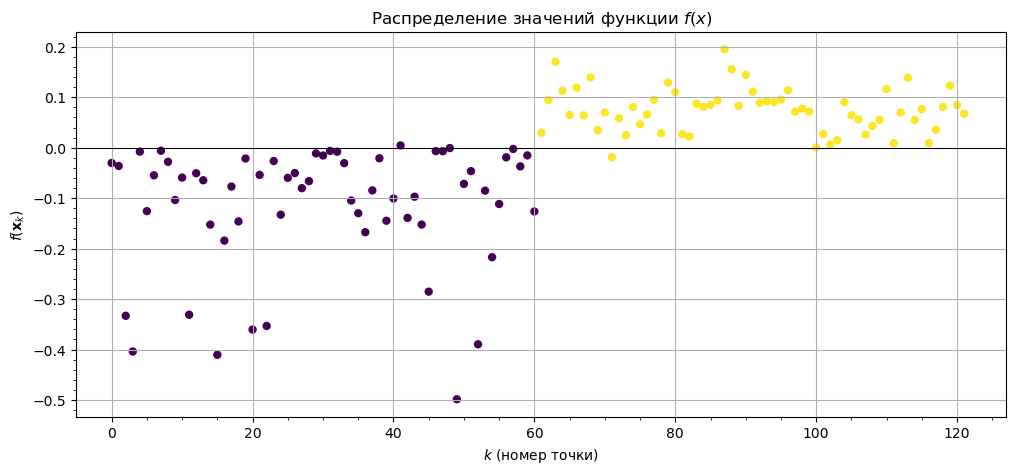

In [12]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1, XX, YY)
plt.show()

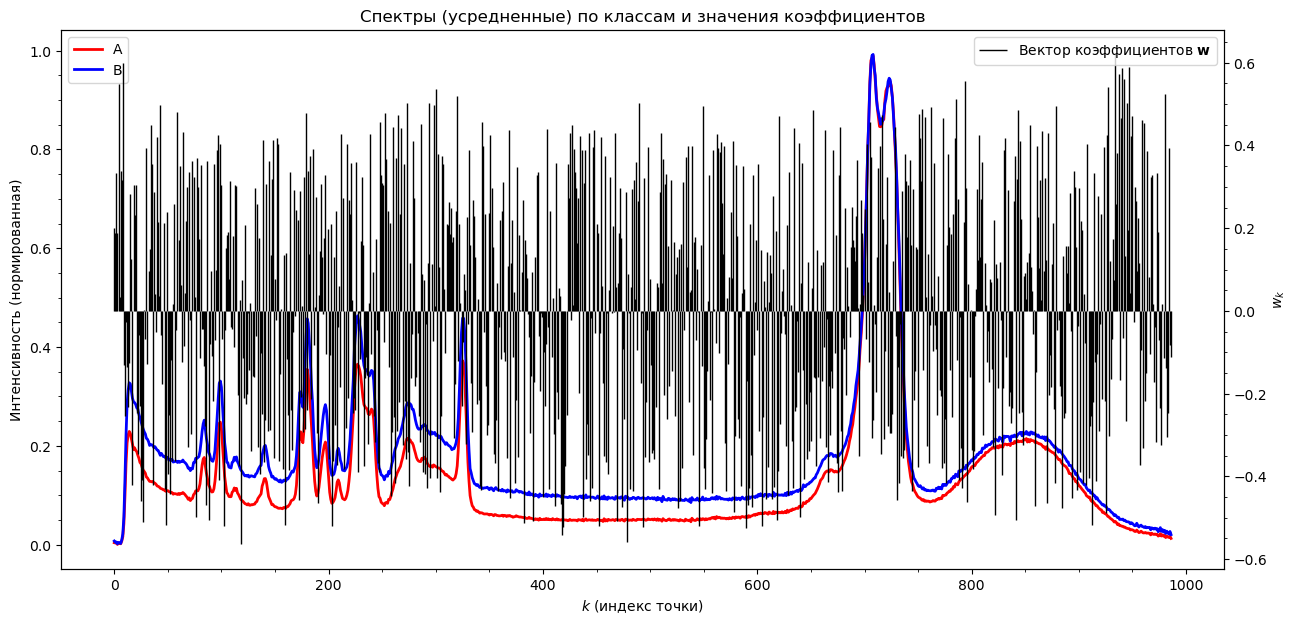

In [13]:
plt.figure(figsize=(15,7))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L2 регуляризация)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_2^2,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [14]:
mod2 = models.LinearModel(n)

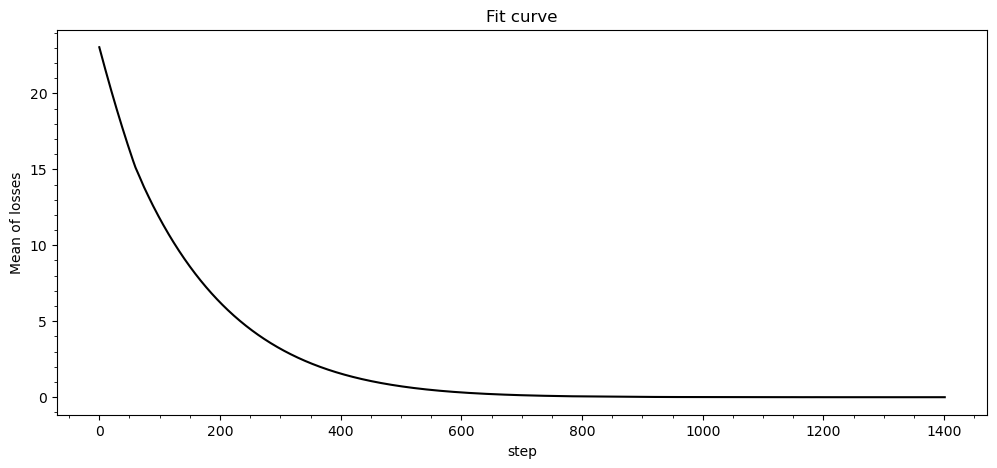

Относительное число правильных ответов: 0.9180327868852459


In [15]:
alg2 = cls.classification_as_regr(XX, YY, mod2,
                                 lossfunc=hinge_loss, 
                                 regnorm=l2_reg, tau=0.5,
                                 normalizer=gd.Masked(mod2, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2, XX, YY)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod2.evaluate_all(XX))))

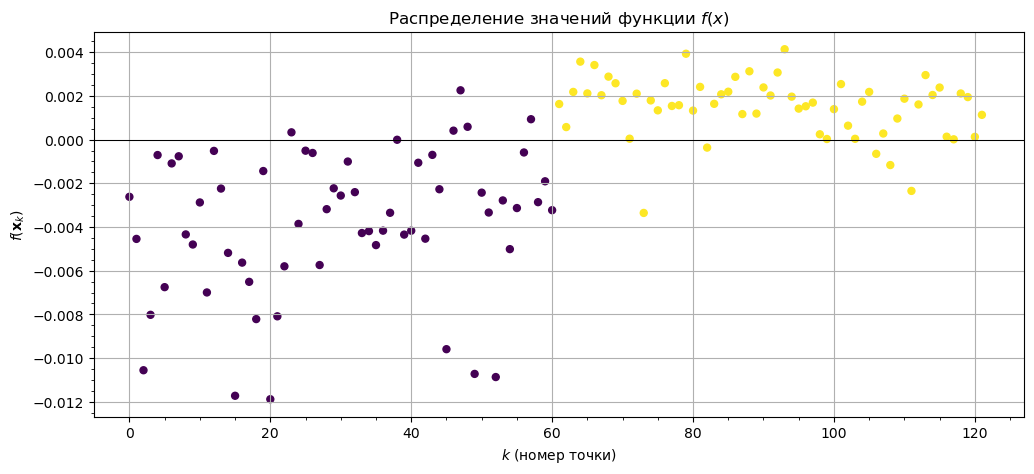

In [16]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2, XX, YY)
plt.show()

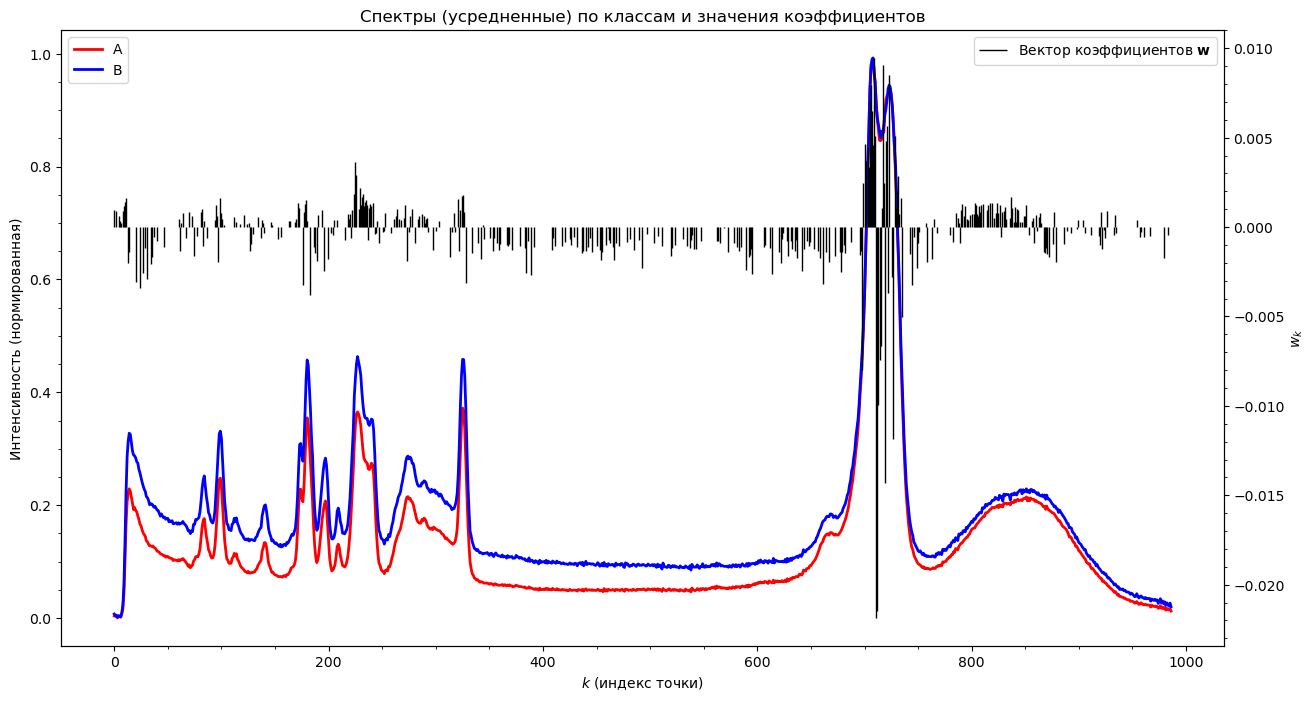

In [17]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + 
\tau\|\mathbf{w}\|_1,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [18]:
mod3 = models.LinearModel(n)

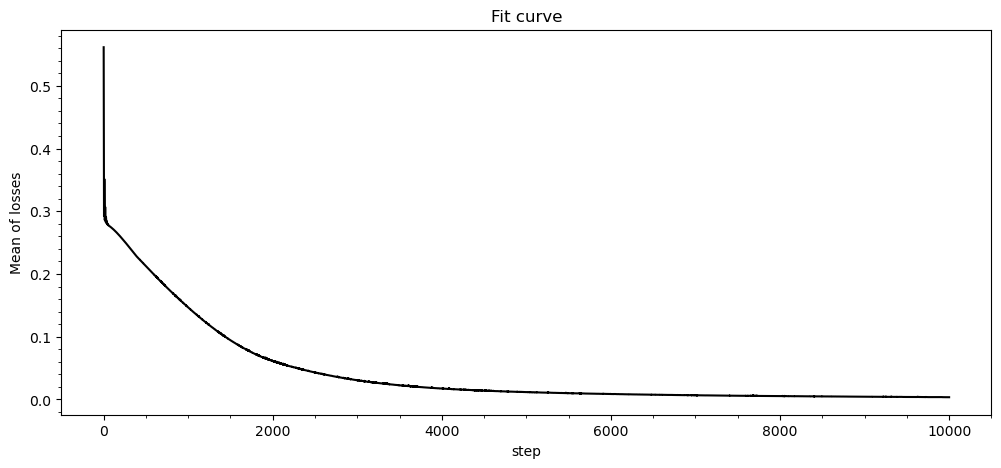

Относительное число правильных ответов: 0.9262295081967213


In [19]:
alg3 = cls.classification_as_regr(XX, YY, mod3,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.001,
                                 normalizer=gd.Masked(mod3, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3, XX, YY)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod3.evaluate_all(XX))))

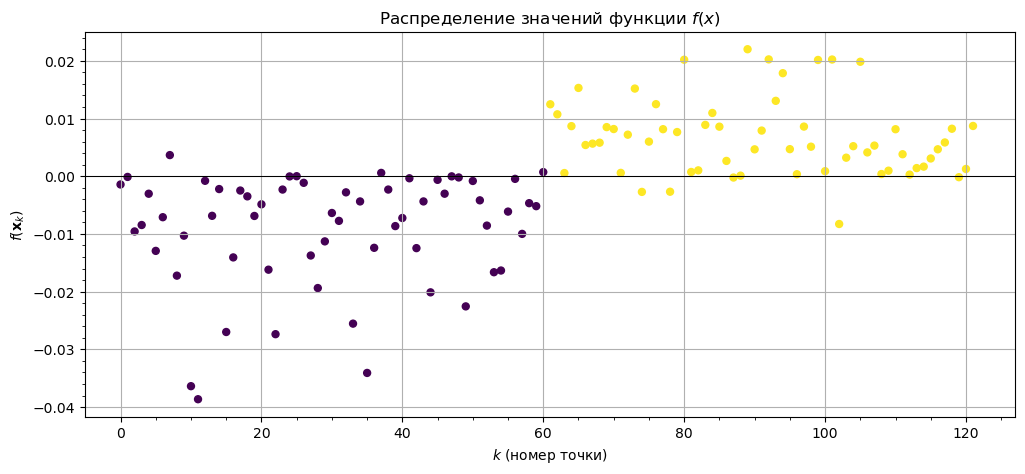

In [20]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3, XX, YY)
plt.show()

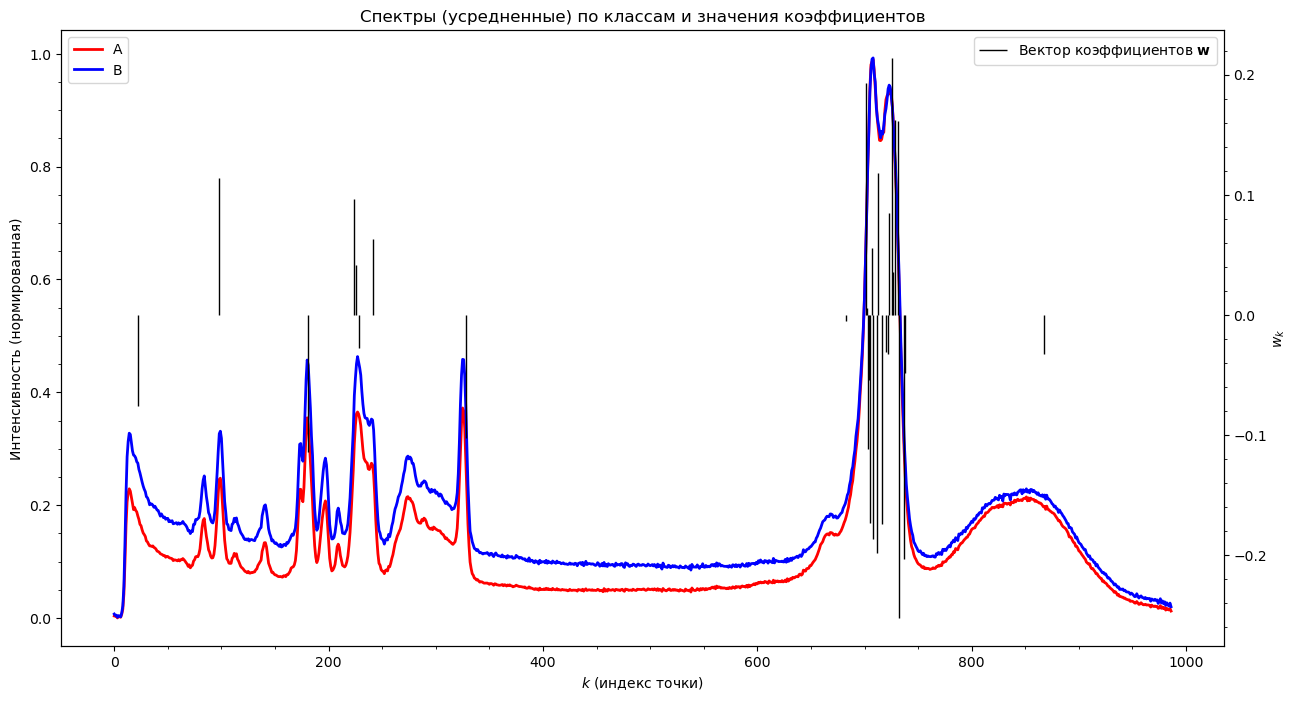

In [21]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3, ax=ax2)
plt.show()

## Линейное разделение (сигмоидальная функция)

$$
y = \sigma\bigl(w_0 + (\mathbf{w},\mathbf{x})\bigr)
$$
где
$$
\sigma(s) = \mathrm{th}(s) = \frac{e^{\alpha x} - e^{-\alpha x}}{e^{\alpha x} + e^{-\alpha x}}
$$

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 
$$


In [22]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod1_s = models.SigmaNeuronModel(sigmoidal_func, n)

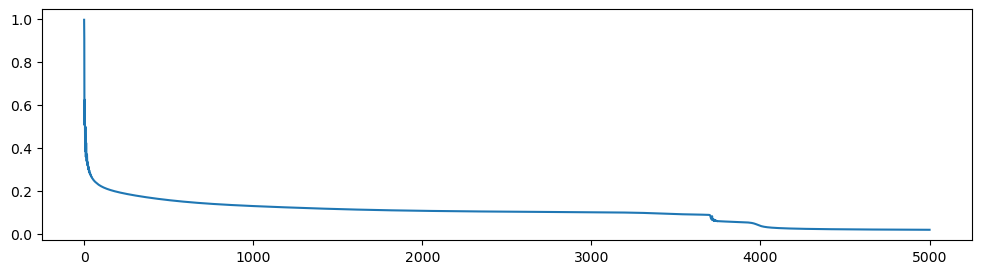

Относительное число правильных ответов: 0.9918032786885246


In [23]:
alg1_s = cls.classification_as_regr(XX, YY, mod1_s,
                                 lossfunc=sq_loss,
                                 normalizer=gd.Masked(mod1_s, 1.0e-9),
                                 h=0.01, n_iter=5000)
plt.figure(figsize=(12,3))
plt.plot(alg1_s.lvals)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod1_s.evaluate_all(XX))))

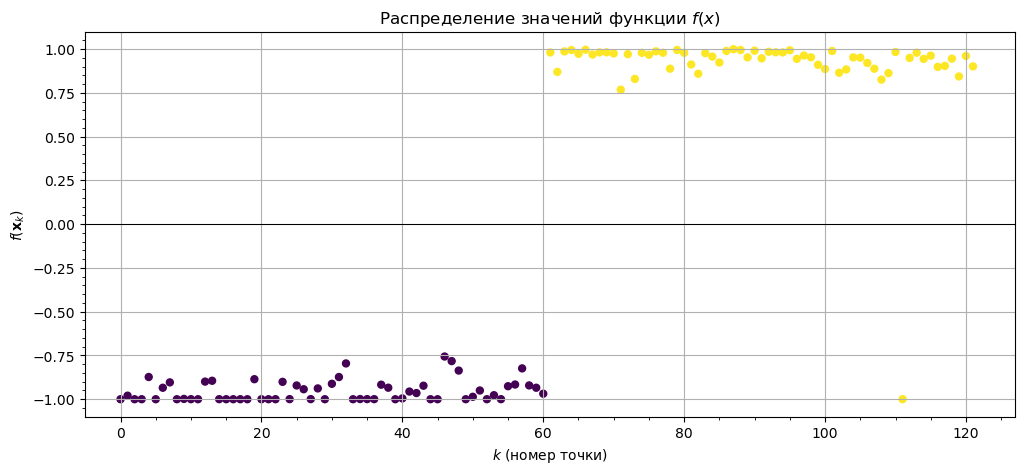

In [24]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1_s, XX, YY)
plt.show()

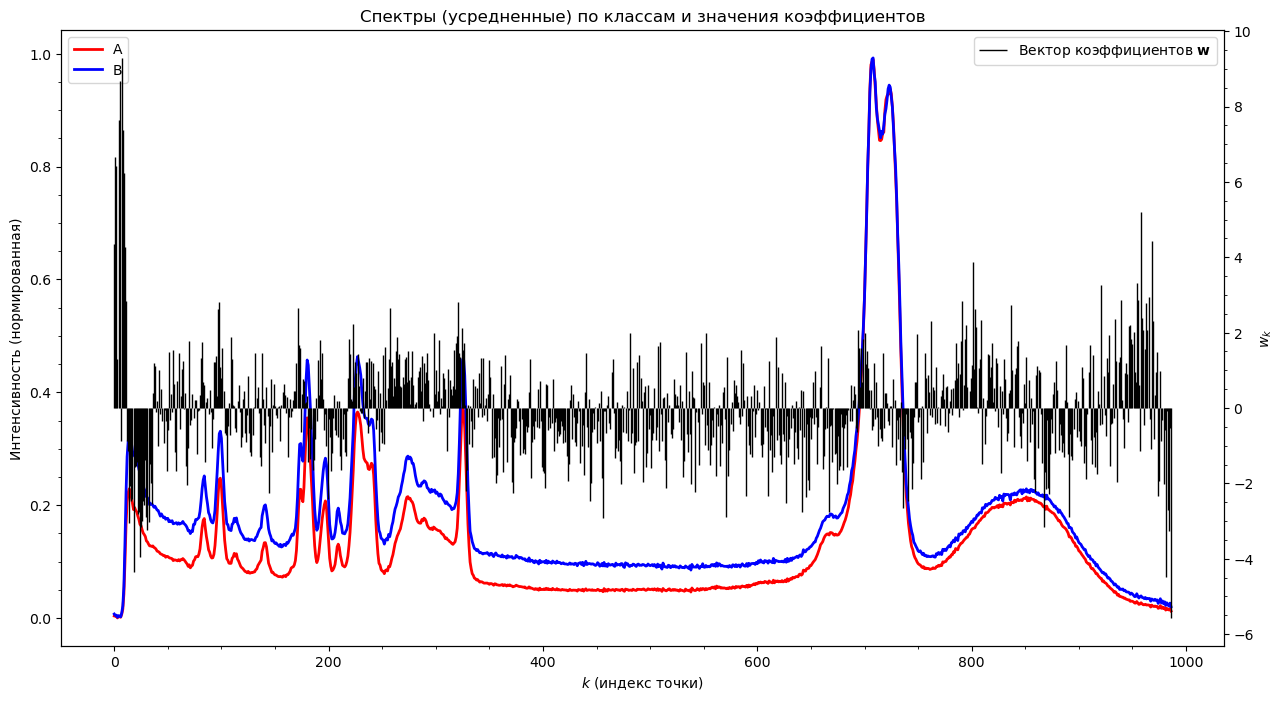

In [25]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1_s, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L2 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 + 
\tau\|\mathbf{w}\|_2^2,
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [26]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod2_s = models.SigmaNeuronModel(sigmoidal_func, n)

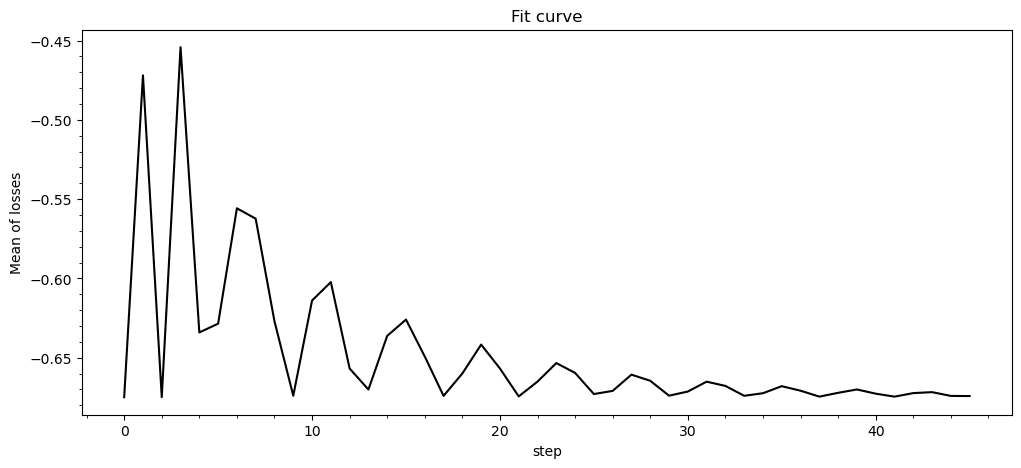

0.9262295081967213

In [34]:
alg2_s = cls.classification_as_regr(XX, YY, mod2_s,
                                 lossfunc=negmargin_loss,
                                 regnorm=l2_reg, tau=0.01,
                                 normalizer=gd.Masked(mod2_s, 1.0e-5),
                                 h=0.01, n_iter=5000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2_s, XX, YY)
plt.show()

metrics.accuracy_score(YY, np.sign(mod2_s.evaluate_all(XX)))

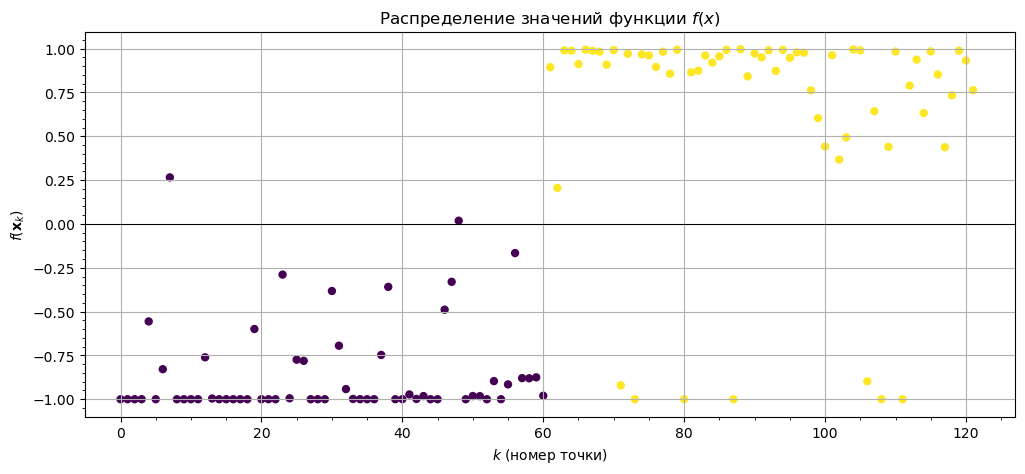

In [28]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2_s, XX, YY)
plt.show()

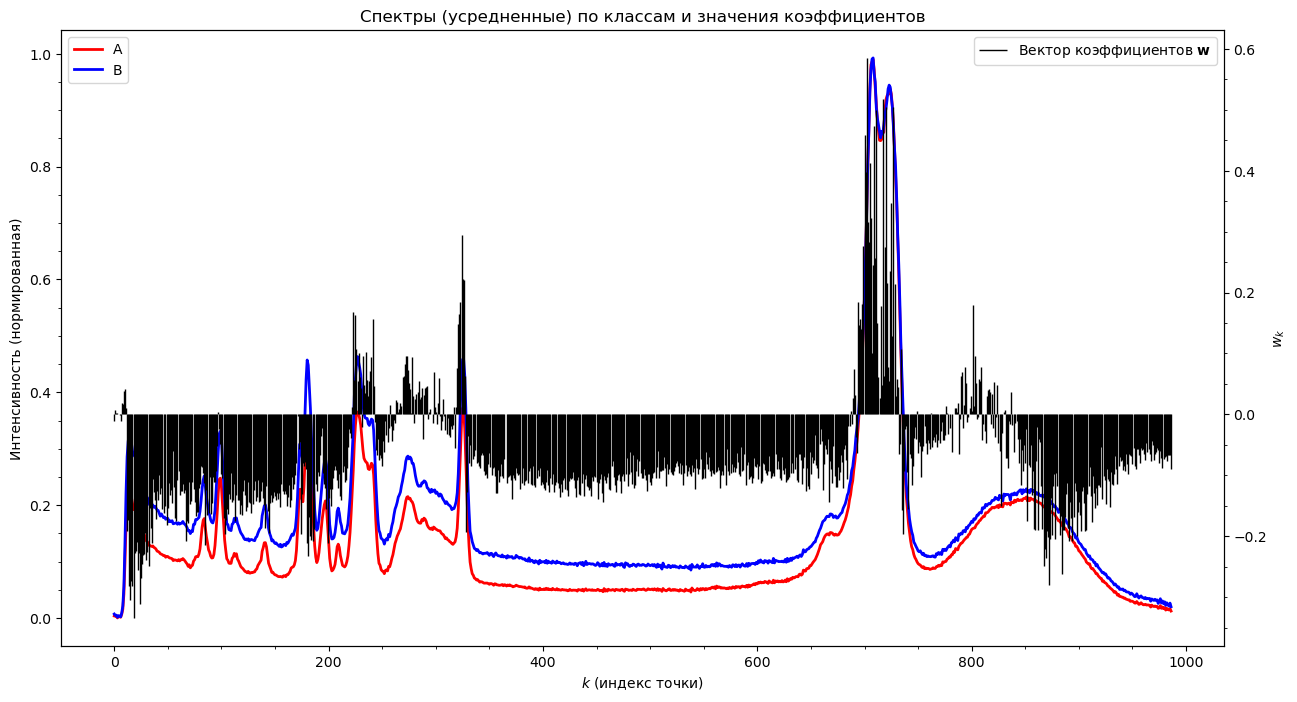

In [29]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2_s, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\sigma\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_1,
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [30]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod3_s = models.SigmaNeuronModel(sigmoidal_func, n)

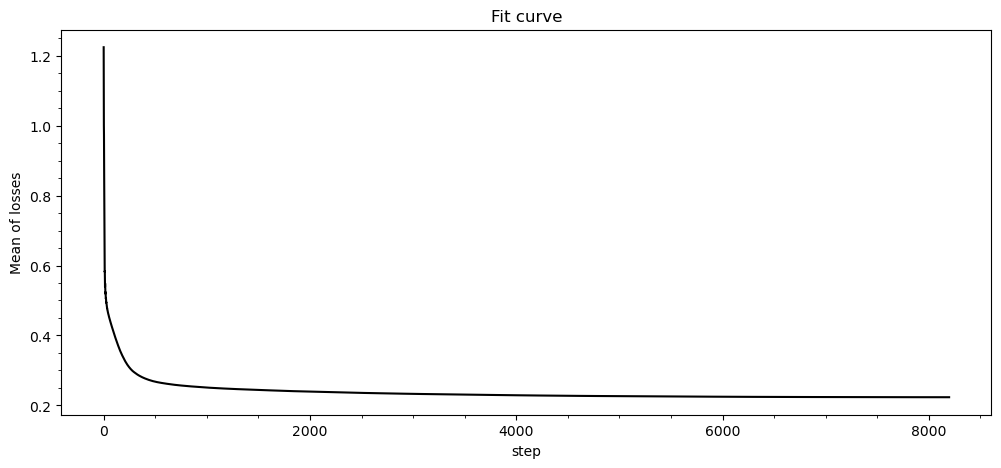

Относительное число правильных ответов: 0.9426229508196722


In [31]:
alg3_s = cls.classification_as_regr(XX, YY, mod3_s,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.001,
                                 normalizer=gd.Masked(mod3_s, 1.0e-5),
                                 h=0.01, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s, XX, YY)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod3_s.evaluate_all(XX))))

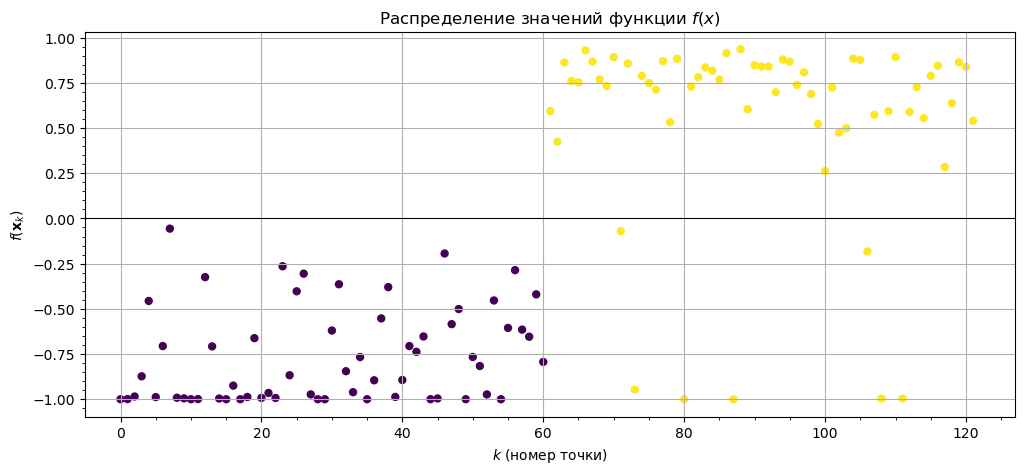

In [32]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s, XX, YY)
plt.show()

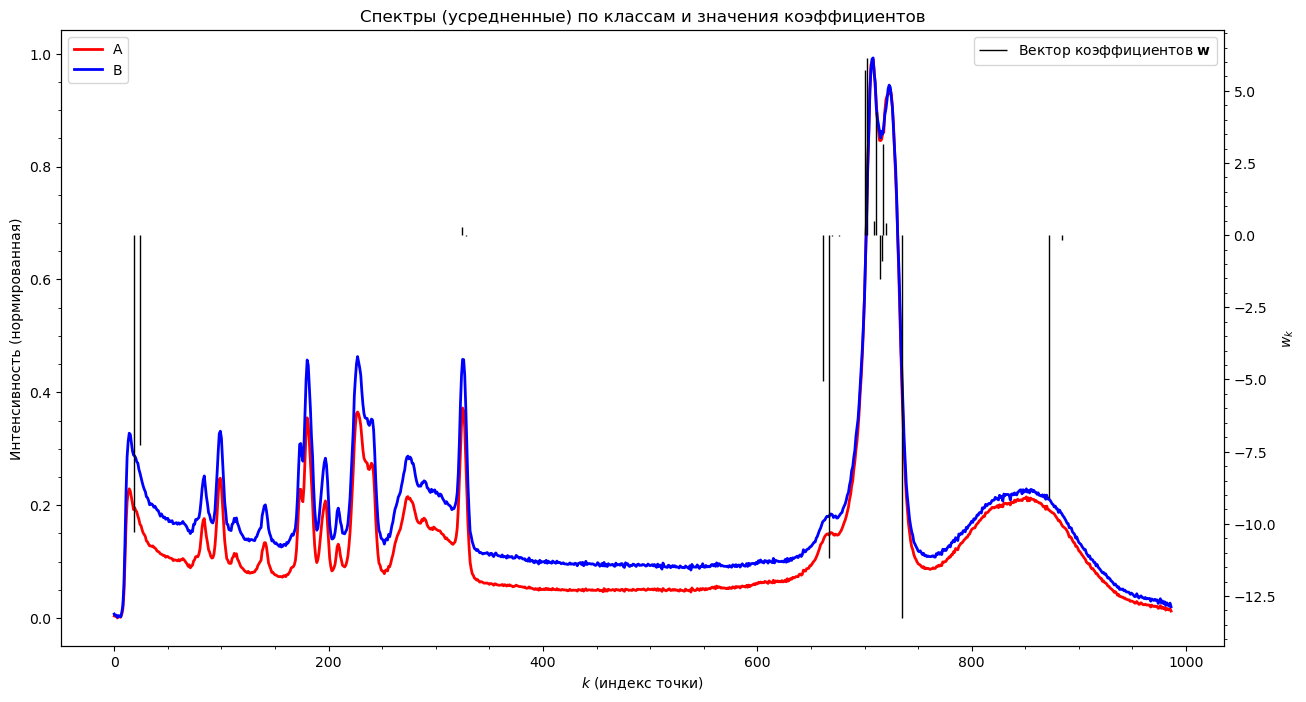

In [33]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3_s, ax=ax2)
plt.show()